In [1]:
import numpy as np

class SingleProductEnvironment:
    def __init__(self, prices, valuation_distribution, horizon, budget):
        self.prices = prices                    # List of possible prices
        self.valuation_distribution = valuation_distribution  # Function: () -> valuation
        self.T = horizon                        # Total time horizon
        self.B = budget                         # Inventory constraint
        self.t = 0                              # Current time step
        self.inventory_used = 0                 # Units sold

    def buyer_valuation(self):
        return self.valuation_distribution()

    def step(self, price):
        """
        Executes one round of interaction with the buyer.
        Returns reward and a flag indicating if a purchase happened.
        """
        if self.inventory_used >= self.B:
            return 0, False  # Budget exhausted

        valuation = self.buyer_valuation()
        if valuation >= price:
            self.inventory_used += 1
            return price, True
        else:
            return 0, False

    def reset(self):
        self.t = 0
        self.inventory_used = 0


In [2]:
class Agent:
    def __init__(self, prices):
        self.prices = prices

    def select_price(self, t):
        raise NotImplementedError

    def update(self, price, reward):
        raise NotImplementedError


## UCB1 ignoring the inventory constraint

In [5]:
import numpy as np

class UCB1Agent(Agent):
    def __init__(self, prices):
        super().__init__(prices)
        self.n_prices = len(prices)
        self.counts = np.zeros(self.n_prices)          # n_i
        self.rewards = np.zeros(self.n_prices)         # cumulative rewards for each price
        self.total_steps = 0

    def select_price(self, t):
        self.total_steps += 1
        if t <= self.n_prices:
            # Play each price once to initialize
            return self.prices[t - 1]
        else:
            avg_rewards = self.rewards / np.maximum(1, self.counts)
            confidence_bounds = np.sqrt((2 * np.log(t)) / np.maximum(1, self.counts))
            ucb_values = avg_rewards + confidence_bounds
            best_index = np.argmax(ucb_values)
            return self.prices[best_index]

    def update(self, price, reward):
        index = self.prices.tolist().index(price)
        self.counts[index] += 1
        self.rewards[index] += reward


In [3]:
def simulate(env, agent):
    rewards = []
    price_choices = []

    for t in range(1, env.T + 1):
        if env.inventory_used >= env.B:
            break

        price = agent.select_price(t)
        reward, _ = env.step(price)

        agent.update(price, reward)

        rewards.append(reward)
        price_choices.append(price)

    return rewards, price_choices


In [80]:
# SIMULATION CODE
# Add more price choices - change discretization
prices = np.round(np.linspace(0.1, 1.0, 100), 2)

valuation_distribution = lambda: np.random.beta(4, 5)

env = SingleProductEnvironment(prices, valuation_distribution, horizon=1000, budget=500)

agent = UCB1Agent(prices)

rewards, choices = simulate(env, agent)

print("Total Revenue:", sum(rewards))

Total Revenue: 82.51000000000026


In [81]:
def estimate_expected_rewards(prices, valuation_distribution, n_samples=100000):
    valuations = np.array([valuation_distribution() for _ in range(n_samples)])
    expected_rewards = [p * np.mean(valuations >= p) for p in prices]
    return np.array(expected_rewards), valuations

def compute_regret_curve(price_choices, prices, expected_rewards):
    best_reward = np.max(expected_rewards)
    chosen_indices = [prices.tolist().index(p) for p in price_choices]
    chosen_rewards = expected_rewards[chosen_indices]
    instantaneous_regret = best_reward - chosen_rewards
    cumulative_regret = np.cumsum(instantaneous_regret)
    return cumulative_regret


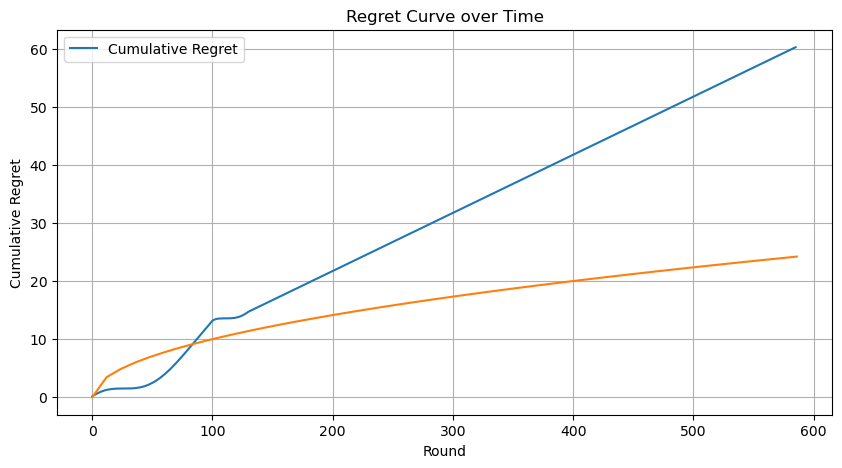

In [82]:
from matplotlib import pyplot as plt
# Estimate true expected rewards
expected_rewards, _ = estimate_expected_rewards(prices, valuation_distribution)

# Compute cumulative regret
cumulative_regret = compute_regret_curve(choices, prices, expected_rewards)
T = np.linspace(0, len(cumulative_regret))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_regret, label="Cumulative Regret")
plt.plot(T, np.sqrt(T))
plt.title("Regret Curve over Time")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.legend()
plt.show()


## UCB1 with inventory constraint 

In [83]:
class UCBInventoryConstraintAgent(Agent):
    def __init__(self, prices, budget):
        super().__init__(prices)
        self.n_prices = len(prices)
        self.counts = np.zeros(self.n_prices)    # n_i
        self.rewards = np.zeros(self.n_prices)   # cumulative rewards
        self.total_steps = 0
        self.budget = budget                     # B
        self.units_sold = 0                      # b_t

    def select_price(self, t):
        self.total_steps += 1
        if t <= self.n_prices:
            # Ensure initial exploration: pull each arm once
            return self.prices[t - 1]
        else:
            avg_rewards = self.rewards / np.maximum(1, self.counts)
            exploration_weight = (self.budget - self.units_sold) / self.budget
            confidence_bonus = exploration_weight * np.sqrt((2 * np.log(t)) / np.maximum(1, self.counts))
            ucb_values = avg_rewards + confidence_bonus
            best_index = np.argmax(ucb_values)
            return self.prices[best_index]

    def update(self, price, reward):
        index = self.prices.tolist().index(price)
        self.counts[index] += 1
        self.rewards[index] += reward
        if reward > 0:
            self.units_sold += 1


In [85]:
# --- Parameters and environment setup ---
prices = np.round(np.linspace(0.1, 1.0, 10), 2)
valuation_distribution = lambda: np.random.beta(2, 5)
budget = 100
horizon = 1000

env = SingleProductEnvironment(prices, valuation_distribution, horizon=horizon, budget=budget)
agent = UCBInventoryConstraintAgent(prices, budget=budget)

# --- Run simulation ---
rewards, price_choices = simulate(env, agent)

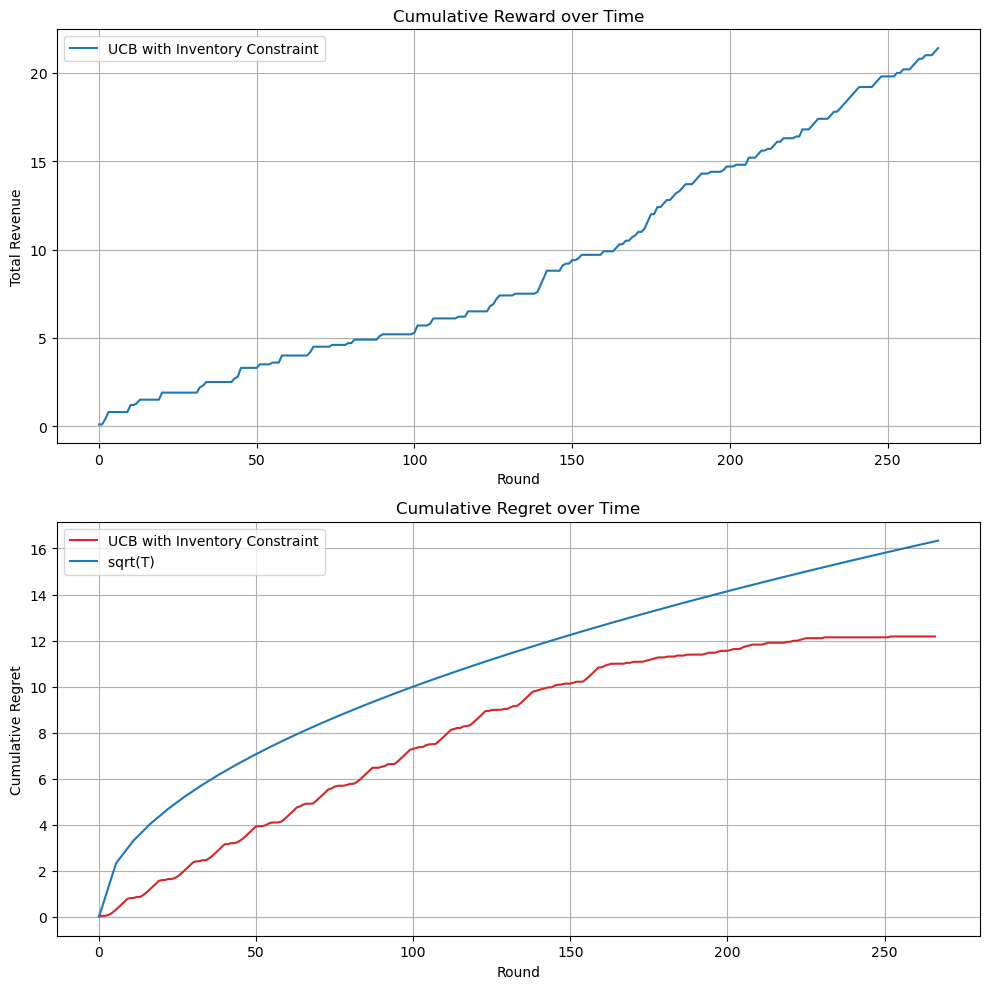

In [89]:
# --- Estimate true expected rewards for regret ---
expected_rewards, _ = estimate_expected_rewards(prices, valuation_distribution)
cumulative_regret = compute_regret_curve(price_choices, prices, expected_rewards)
cumulative_reward = np.cumsum(rewards)

T = np.linspace(0, len(cumulative_regret))

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot cumulative reward
axs[0].plot(cumulative_reward, label="UCB with Inventory Constraint", color='tab:blue')
axs[0].set_title("Cumulative Reward over Time")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Total Revenue")
axs[0].legend()
axs[0].grid(True)

# Plot cumulative regret
axs[1].plot(cumulative_regret, label="UCB with Inventory Constraint", color='tab:red')
axs[1].plot(T, np.sqrt(T), label="sqrt(T) ")
axs[1].set_title("Cumulative Regret over Time")
axs[1].set_xlabel("Round")
axs[1].set_ylabel("Cumulative Regret")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Requirement 2 - Multiple products and stochastic environment

In [98]:
class MultiProductEnvironment:
    def __init__(self, price_sets, valuation_distribution, horizon, budget):
        """
        price_sets: list of arrays, one for each product's possible prices
        valuation_distribution: function that returns a vector of valuations (1 per product)
        """
        self.price_sets = price_sets
        self.N = len(price_sets)  # Number of products
        self.valuation_distribution = valuation_distribution
        self.T = horizon
        self.B = budget
        self.inventory_used = 0

    def buyer_valuation(self):
        return self.valuation_distribution()

    def step(self, price_vector):
        """
        price_vector: selected prices for each product, one per product
        Returns:
            rewards: list of rewards per product
            purchased_flags: list of booleans per product
        """
        if self.inventory_used >= self.B:
            return [0]*self.N, [False]*self.N  # budget exhausted

        valuations = self.buyer_valuation()
        rewards = []
        purchased_flags = []
        for i in range(self.N):
            if valuations[i] >= price_vector[i]:
                rewards.append(price_vector[i])
                purchased_flags.append(True)
            else:
                rewards.append(0)
                purchased_flags.append(False)

        self.inventory_used += sum(purchased_flags)
        return rewards, purchased_flags

    def reset(self):
        self.inventory_used = 0


In [99]:
class CombinatorialUCB(Agent):
    def __init__(self, price_sets):
        """
        price_sets: list of arrays, one for each product's possible prices
        """
        self.price_sets = price_sets
        self.N = len(price_sets)
        self.K = [len(ps) for ps in price_sets]  # number of arms per product

        # Initialize counts and rewards
        self.counts = [np.zeros(k) for k in self.K]     # per product
        self.rewards = [np.zeros(k) for k in self.K]
        self.total_steps = 0

    def select_price(self, t):
        """
        Selects a price for each product using UCB.
        """
        price_vector = []
        for i in range(self.N):
            if t <= self.K[i]:
                # play each arm once for product i
                price_vector.append(self.price_sets[i][t % self.K[i]])
            else:
                avg_rewards = self.rewards[i] / np.maximum(1, self.counts[i])
                confidence = np.sqrt((2 * np.log(t)) / np.maximum(1, self.counts[i]))
                ucb = avg_rewards + confidence
                best_arm = np.argmax(ucb)
                price_vector.append(self.price_sets[i][best_arm])
        return price_vector

    def update(self, price_vector, rewards):
        """
        Update statistics after observing reward vector.
        """
        for i in range(self.N):
            price = price_vector[i]
            reward = rewards[i]
            price_list = self.price_sets[i].tolist()
            index = price_list.index(price)
            self.counts[i][index] += 1
            self.rewards[i][index] += reward
        self.total_steps += 1


[[0.20723997]]


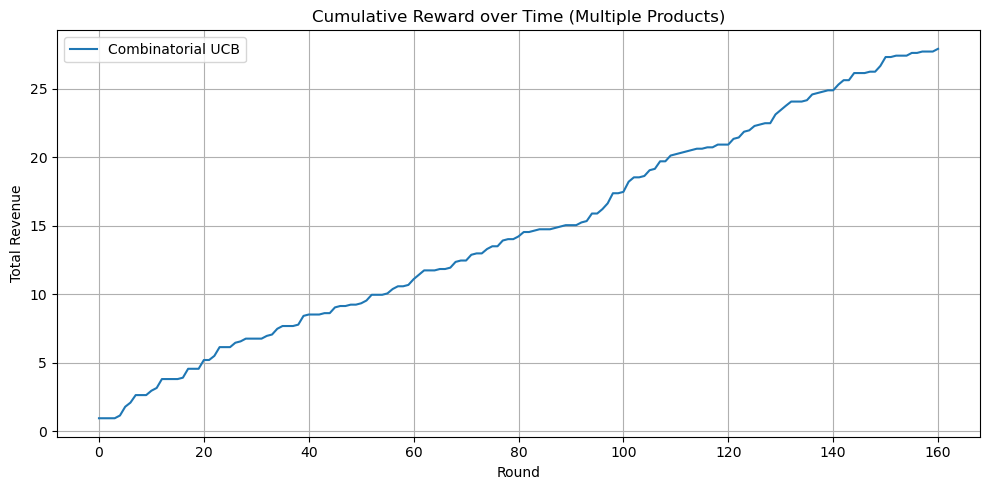

In [109]:
# Define simulation for multi-product setting
def simulate_multi(env, agent):
    rewards_total = []
    price_choices = []
    
    for t in range(1, env.T + 1):
        if env.inventory_used >= env.B:
            break
        price_vector = agent.select_price(t)
        rewards, _ = env.step(price_vector)
        agent.update(price_vector, rewards)
        rewards_total.append(sum(rewards))
        price_choices.append(price_vector)
    return rewards_total, price_choices

# Setup for 3 products
price_sets = [np.round(np.linspace(0.1, 1.0, 5), 2) for _ in range(3)]  # 5 price points per product

# Joint valuation distribution (independent Beta(2,5) per product)
valuation_distribution = lambda: np.random.beta(2, 5, size=3)

horizon = 1000
budget = 150

# Create environment and agent
env = MultiProductEnvironment(price_sets, valuation_distribution, horizon, budget)
agent = CombinatorialUCB(price_sets)

# Run simulation
rewards, price_choices = simulate_multi(env, agent)
cumulative_rewards = np.cumsum(rewards)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_rewards, label="Combinatorial UCB")
plt.title("Cumulative Reward over Time (Multiple Products)")
plt.xlabel("Round")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


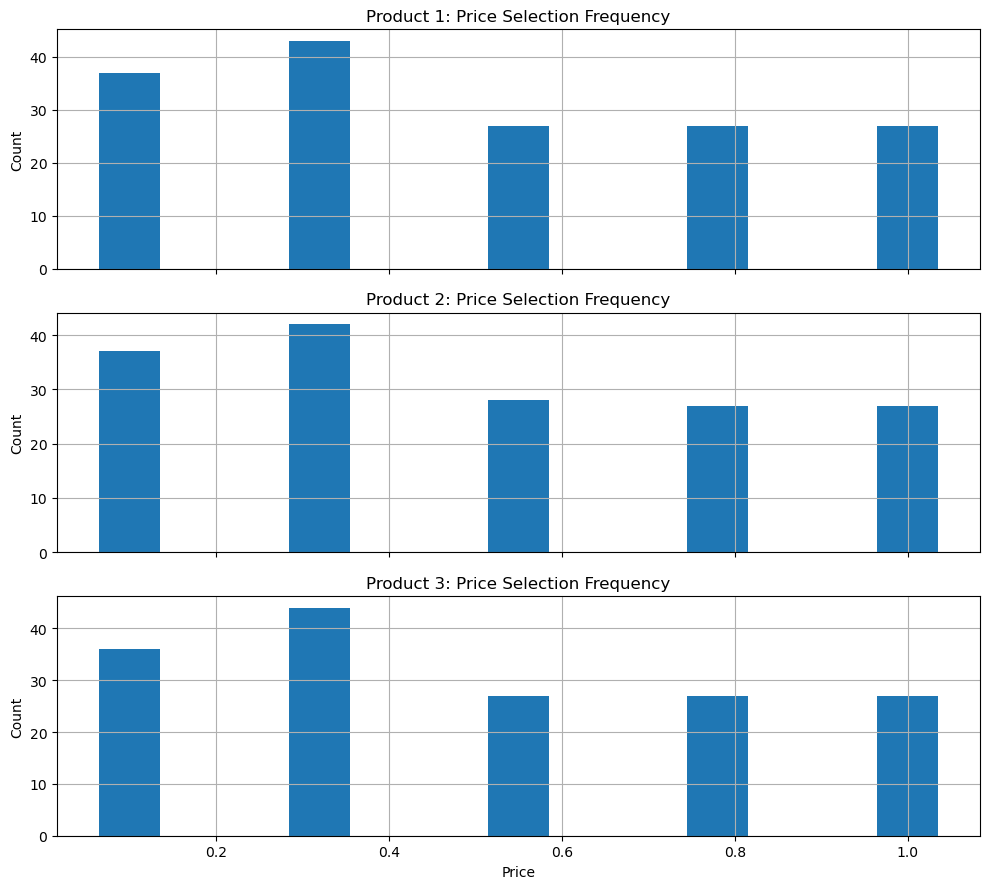

In [94]:
# Prepare data for plotting per-product statistics
N = len(price_sets)  # number of products
price_counts = [np.zeros(len(price_sets[i])) for i in range(N)]

# Count how often each price was chosen for each product
for vector in price_choices:
    for i in range(N):
        price = vector[i]
        idx = price_sets[i].tolist().index(price)
        price_counts[i][idx] += 1

# Plot histograms of price selections per product
fig, axs = plt.subplots(N, 1, figsize=(10, 3 * N), sharex=True)

for i in range(N):
    axs[i].bar(price_sets[i], price_counts[i], width=0.07)
    axs[i].set_title(f"Product {i+1}: Price Selection Frequency")
    axs[i].set_ylabel("Count")
    axs[i].grid(True)

axs[-1].set_xlabel("Price")
plt.tight_layout()
plt.show()


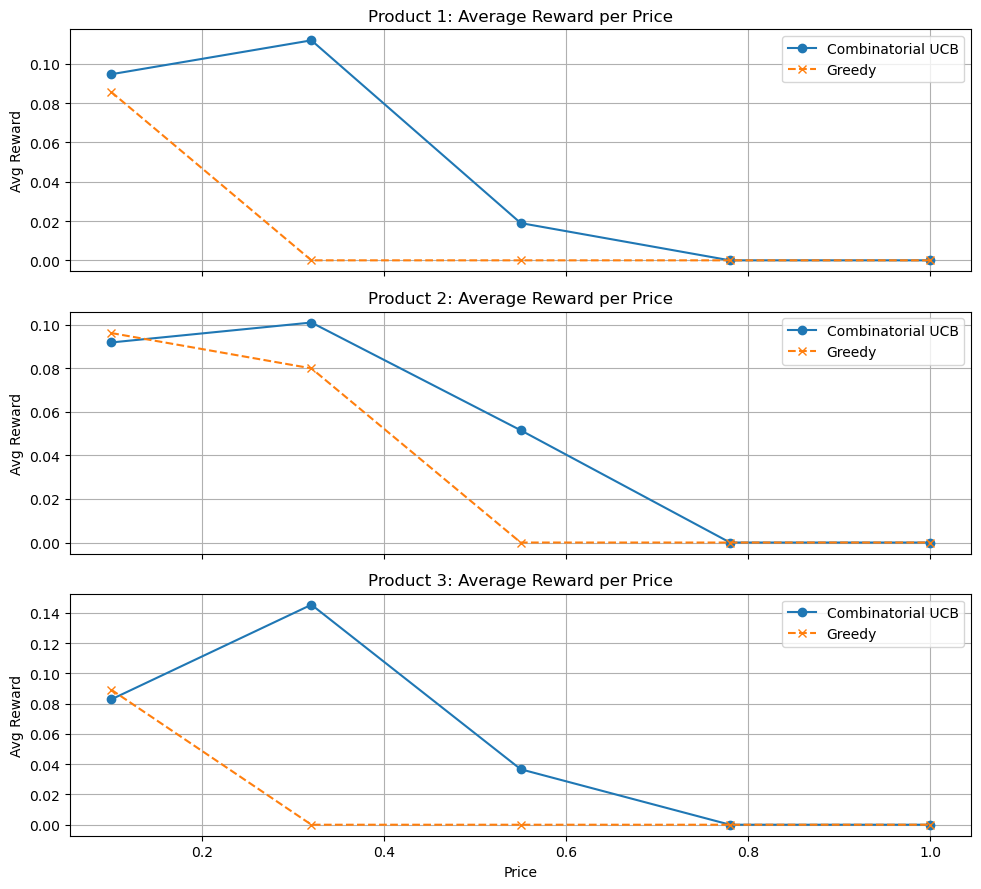

In [110]:
# Define greedy agent for comparison
class GreedyAgent(Agent):
    def __init__(self, price_sets):
        self.price_sets = price_sets
        self.N = len(price_sets)
        self.K = [len(ps) for ps in price_sets]
        self.counts = [np.zeros(k) for k in self.K]
        self.rewards = [np.zeros(k) for k in self.K]
        self.total_steps = 0

    def select_price(self, t):
        price_vector = []
        for i in range(self.N):
            if t <= self.K[i]:
                price_vector.append(self.price_sets[i][t % self.K[i]])
            else:
                avg_rewards = self.rewards[i] / np.maximum(1, self.counts[i])
                best_arm = np.argmax(avg_rewards)
                price_vector.append(self.price_sets[i][best_arm])
        return price_vector

    def update(self, price_vector, rewards):
        for i in range(self.N):
            price = price_vector[i]
            reward = rewards[i]
            price_list = self.price_sets[i].tolist()
            index = price_list.index(price)
            self.counts[i][index] += 1
            self.rewards[i][index] += reward
        self.total_steps += 1

# Simulate greedy agent
env_greedy = MultiProductEnvironment(price_sets, valuation_distribution, horizon, budget)
agent_greedy = GreedyAgent(price_sets)
rewards_greedy, _ = simulate_multi(env_greedy, agent_greedy)

# Compute average reward over time per product for both agents
def average_reward_per_product(agent, price_sets):
    avg_rewards = []
    for i in range(len(price_sets)):
        counts = np.maximum(agent.counts[i], 1)
        avg = agent.rewards[i] / counts
        avg_rewards.append(avg)
    return avg_rewards

avg_rewards_ucb = average_reward_per_product(agent, price_sets)
avg_rewards_greedy = average_reward_per_product(agent_greedy, price_sets)

# Plot average reward per product
fig, axs = plt.subplots(N, 1, figsize=(10, 3 * N), sharex=True)

for i in range(N):
    axs[i].plot(price_sets[i], avg_rewards_ucb[i], 'o-', label='Combinatorial UCB')
    axs[i].plot(price_sets[i], avg_rewards_greedy[i], 'x--', label='Greedy')
    axs[i].set_title(f"Product {i+1}: Average Reward per Price")
    axs[i].set_ylabel("Avg Reward")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Price")
plt.tight_layout()
plt.show()
